In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set(style='whitegrid')

In [10]:
# Load the log file 
with open('data/log_sample2.txt', 'r', encoding='utf-8') as f:
    raw_log = f.read()

In [11]:
# Parse log lines with timestamps and events
pattern = r"\[(.*?)\]\[(.*?)\]: (.*?)$"
matches = re.findall(pattern, raw_log, re.MULTILINE)

log_df = pd.DataFrame(matches, columns=['timestamp', 'event', 'event_time'])
log_df['timestamp'] = pd.to_datetime(log_df['timestamp'])
log_df['event_time'] = pd.to_datetime(log_df['event_time'], errors='coerce')
log_df['event_type'] = log_df['event'].str.extract(r'(✅|🤖|📋|🚀)')
log_df['event_desc'] = log_df['event'].str.replace(r'(✅|🤖|📋|🚀)', '', regex=True).str.strip()

log_df.head()

,timestamp,event,event_time,event_type,event_desc
0,2025-03-20 14:00:24,✅ LLM CALL COMPLETED,2025-03-20 14:00:24.841843,✅,LLM CALL COMPLETED
1,2025-03-20 14:00:24,🤖 LLM CALL STARTED,2025-03-20 14:00:24.841843,🤖,LLM CALL STARTED
2,2025-03-20 14:00:43,✅ LLM CALL COMPLETED,2025-03-20 14:00:43.652146,✅,LLM CALL COMPLETED
3,2025-03-20 14:00:43,🤖 LLM CALL STARTED,2025-03-20 14:00:43.669219,🤖,LLM CALL STARTED
4,2025-03-20 14:00:45,✅ LLM CALL COMPLETED,2025-03-20 14:00:45.248921,✅,LLM CALL COMPLETED


In [12]:
# Duration calculations (for STARTED/COMPLETED pairs)
duration_df = []

for event_prefix in ['LLM CALL', 'TOOL USAGE']:
    start_mask = log_df['event_desc'].str.startswith(f"{event_prefix} STARTED")
    end_mask = log_df['event_desc'].str.startswith(f"{event_prefix} COMPLETED") | \
                log_df['event_desc'].str.startswith(f"{event_prefix} FINISHED")

    starts = log_df[start_mask].copy()
    ends = log_df[end_mask].copy()

    for i, start in starts.iterrows():
        later_ends = ends[ends['timestamp'] > start['timestamp']]
        if not later_ends.empty:
            end = later_ends.iloc[0]
            duration = (end['timestamp'] - start['timestamp']).total_seconds()
            duration_df.append({
                'Type': event_prefix,
                'Start': start['timestamp'],
                'End': end['timestamp'],
                'Duration (s)': duration
            })
            ends.drop(end.name, inplace=True)

duration_df = pd.DataFrame(duration_df)
duration_df

,Type,Start,End,Duration (s)
0,LLM CALL,2025-03-20 14:00:24,2025-03-20 14:00:43,19.0
1,LLM CALL,2025-03-20 14:00:43,2025-03-20 14:00:45,2.0
2,LLM CALL,2025-03-20 14:00:46,2025-03-20 14:00:48,2.0
3,LLM CALL,2025-03-20 14:00:49,2025-03-20 14:00:51,2.0
4,LLM CALL,2025-03-20 14:00:51,2025-03-20 14:00:53,2.0
5,LLM CALL,2025-03-20 14:00:54,2025-03-20 14:00:55,1.0
6,LLM CALL,2025-03-20 14:00:56,2025-03-20 14:00:58,2.0
7,LLM CALL,2025-03-20 14:02:37,2025-03-20 14:02:39,2.0
8,LLM CALL,2025-03-20 14:02:40,2025-03-20 14:02:42,2.0
9,LLM CALL,2025-03-20 14:02:42,2025-03-20 14:02:44,2.0


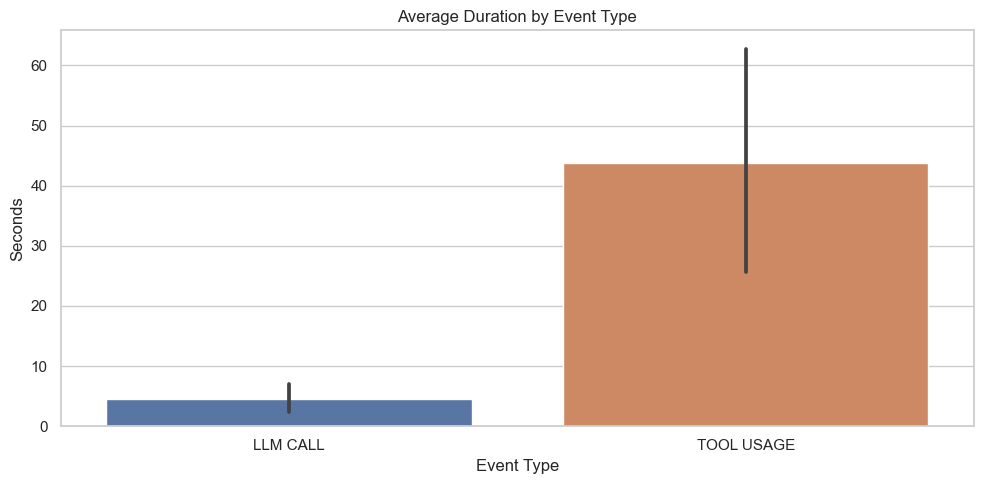

In [13]:
plt.figure(figsize=(10, 5))
sns.barplot(data=duration_df, x='Type', y='Duration (s)', estimator='mean')
plt.title('Average Duration by Event Type')
plt.ylabel('Seconds')
plt.xlabel('Event Type')
plt.tight_layout()
plt.show()

In [14]:
agent_lines = [line for line in raw_log.splitlines() if line.startswith('# Agent:')]
agents = [line.split(':', 1)[1].strip() for line in agent_lines]

agent_df = pd.DataFrame(agents, columns=['Agent'])
agent_summary = agent_df['Agent'].value_counts().reset_index()
agent_summary.columns = ['Agent', 'Task Count']
agent_summary

,Agent,Task Count
0,Certified Internal Auditor (CIA) - Director of...,25


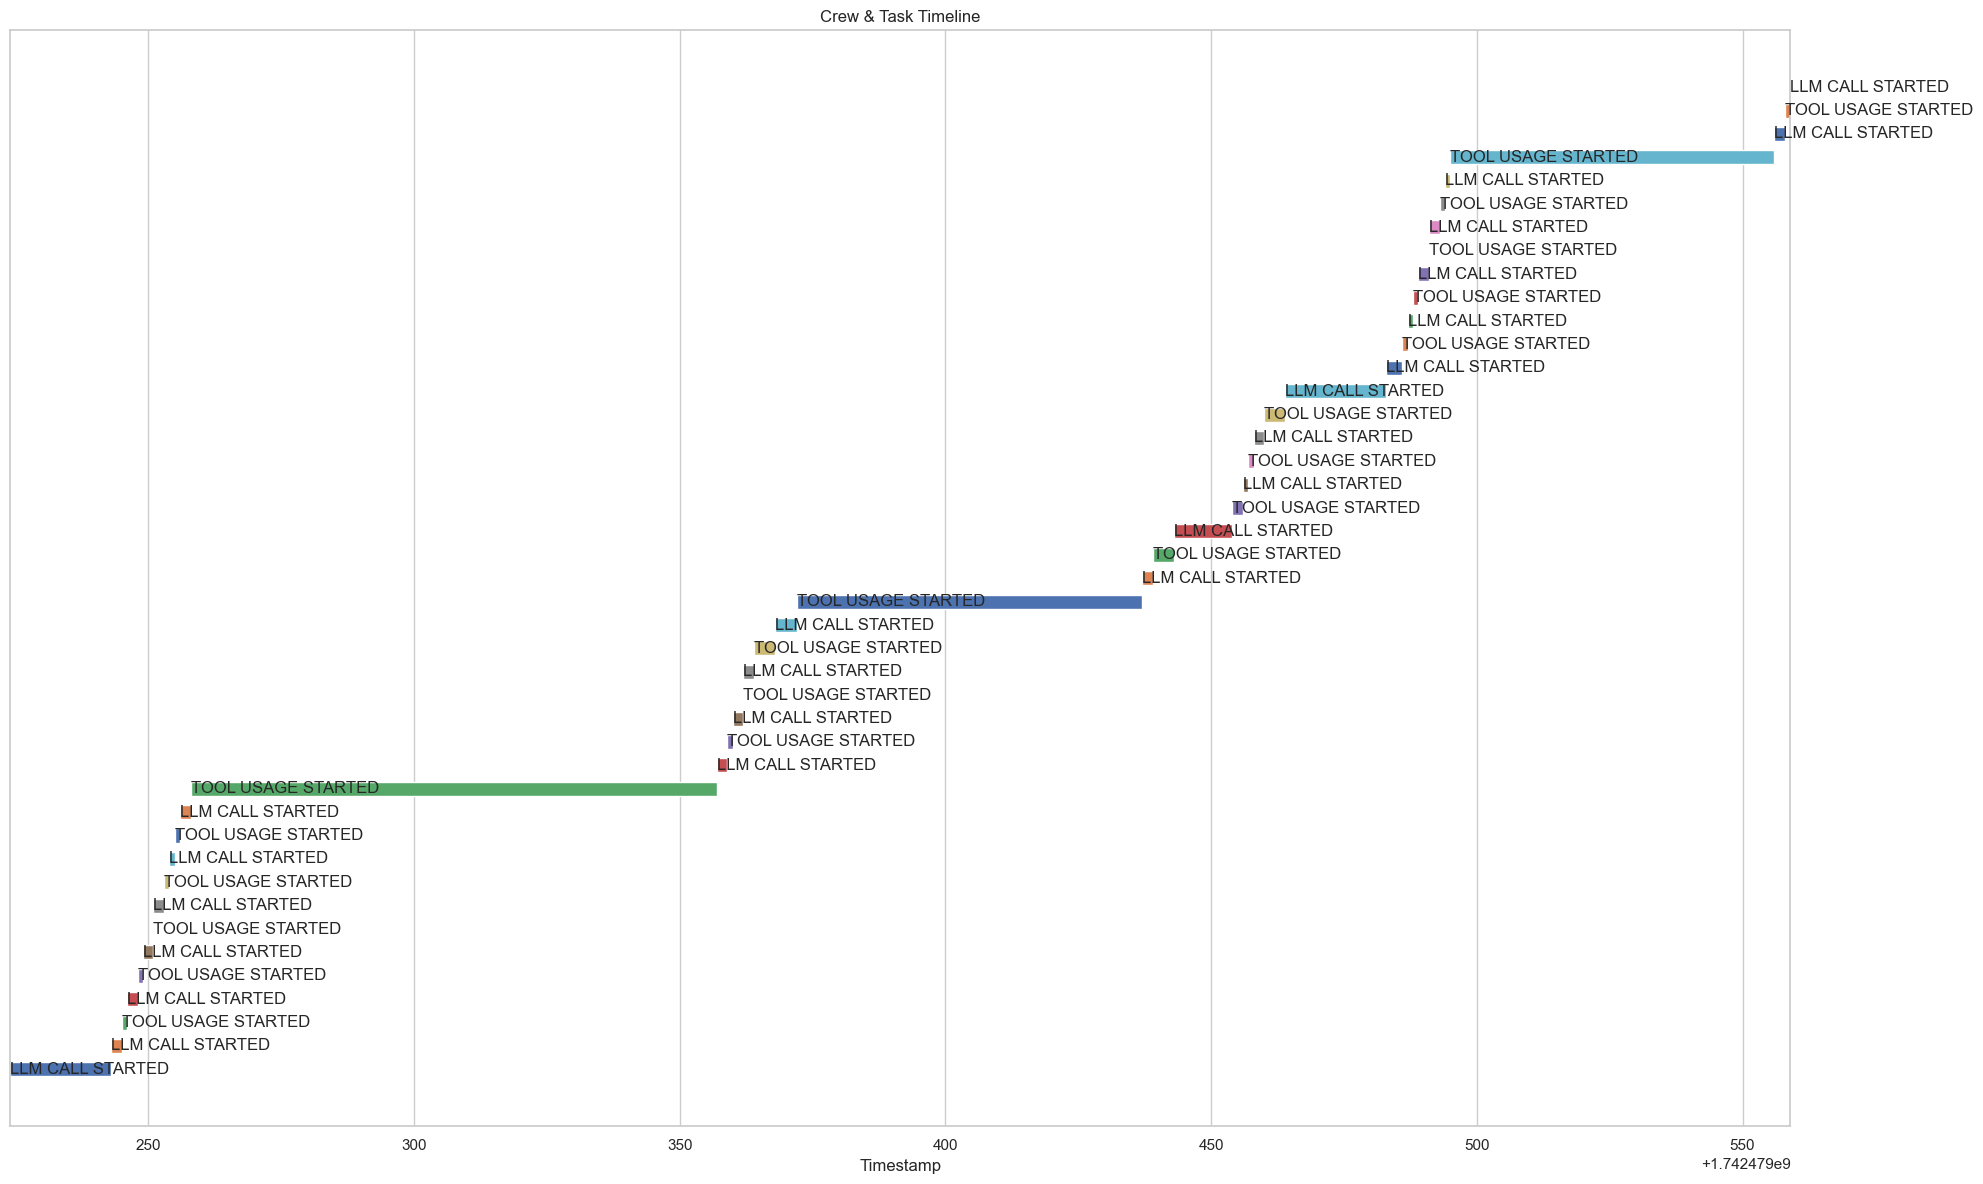

In [15]:
gantt_data = []

for i, row in log_df.iterrows():
    if 'STARTED' in row['event_desc'] or 'CREW' in row['event_desc']:
        label = row['event_desc'].split(':')[0] if ':' in row['event_desc'] else row['event_desc']
        gantt_data.append({
            'Label': label,
            'Start': row['timestamp']
        })

timeline_df = pd.DataFrame(gantt_data)
timeline_df['End'] = timeline_df['Start'].shift(-1)
timeline_df = timeline_df.dropna()
timeline_df['Duration'] = (timeline_df['End'] - timeline_df['Start']).dt.total_seconds()

plt.figure(figsize=(20, 12))
for i, row in timeline_df.iterrows():
    plt.barh(i, row['Duration'], left=row['Start'].timestamp(), height=0.6)
    plt.text(row['Start'].timestamp(), i, row['Label'], va='center', ha='left')
plt.yticks([])
plt.title('Crew & Task Timeline')
plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

In [19]:
tool_usage = log_df[log_df['event_desc'].str.contains('TOOL USAGE')]
tool_usage['Tool Name'] = tool_usage['event_desc'].str.extract(r"'([^']+)'")

tool_summary = tool_usage['Tool Name'].value_counts().reset_index()
tool_summary.columns = ['Tool', 'Usage Count']
tool_summary

/var/folders/y2/nrbfqcrj6v1d6lh4rdmsd4h00000gn/T/ipykernel_70072/230689169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tool_usage['Tool Name'] = tool_usage['event_desc'].str.extract(r"'([^']+)'")


,Tool,Usage Count
0,SEARCH THE INTERNET WITH SERPER,20
1,SEARCH IN A SPECIFIC WEBSITE,17
2,READ WEBSITE CONTENT,6


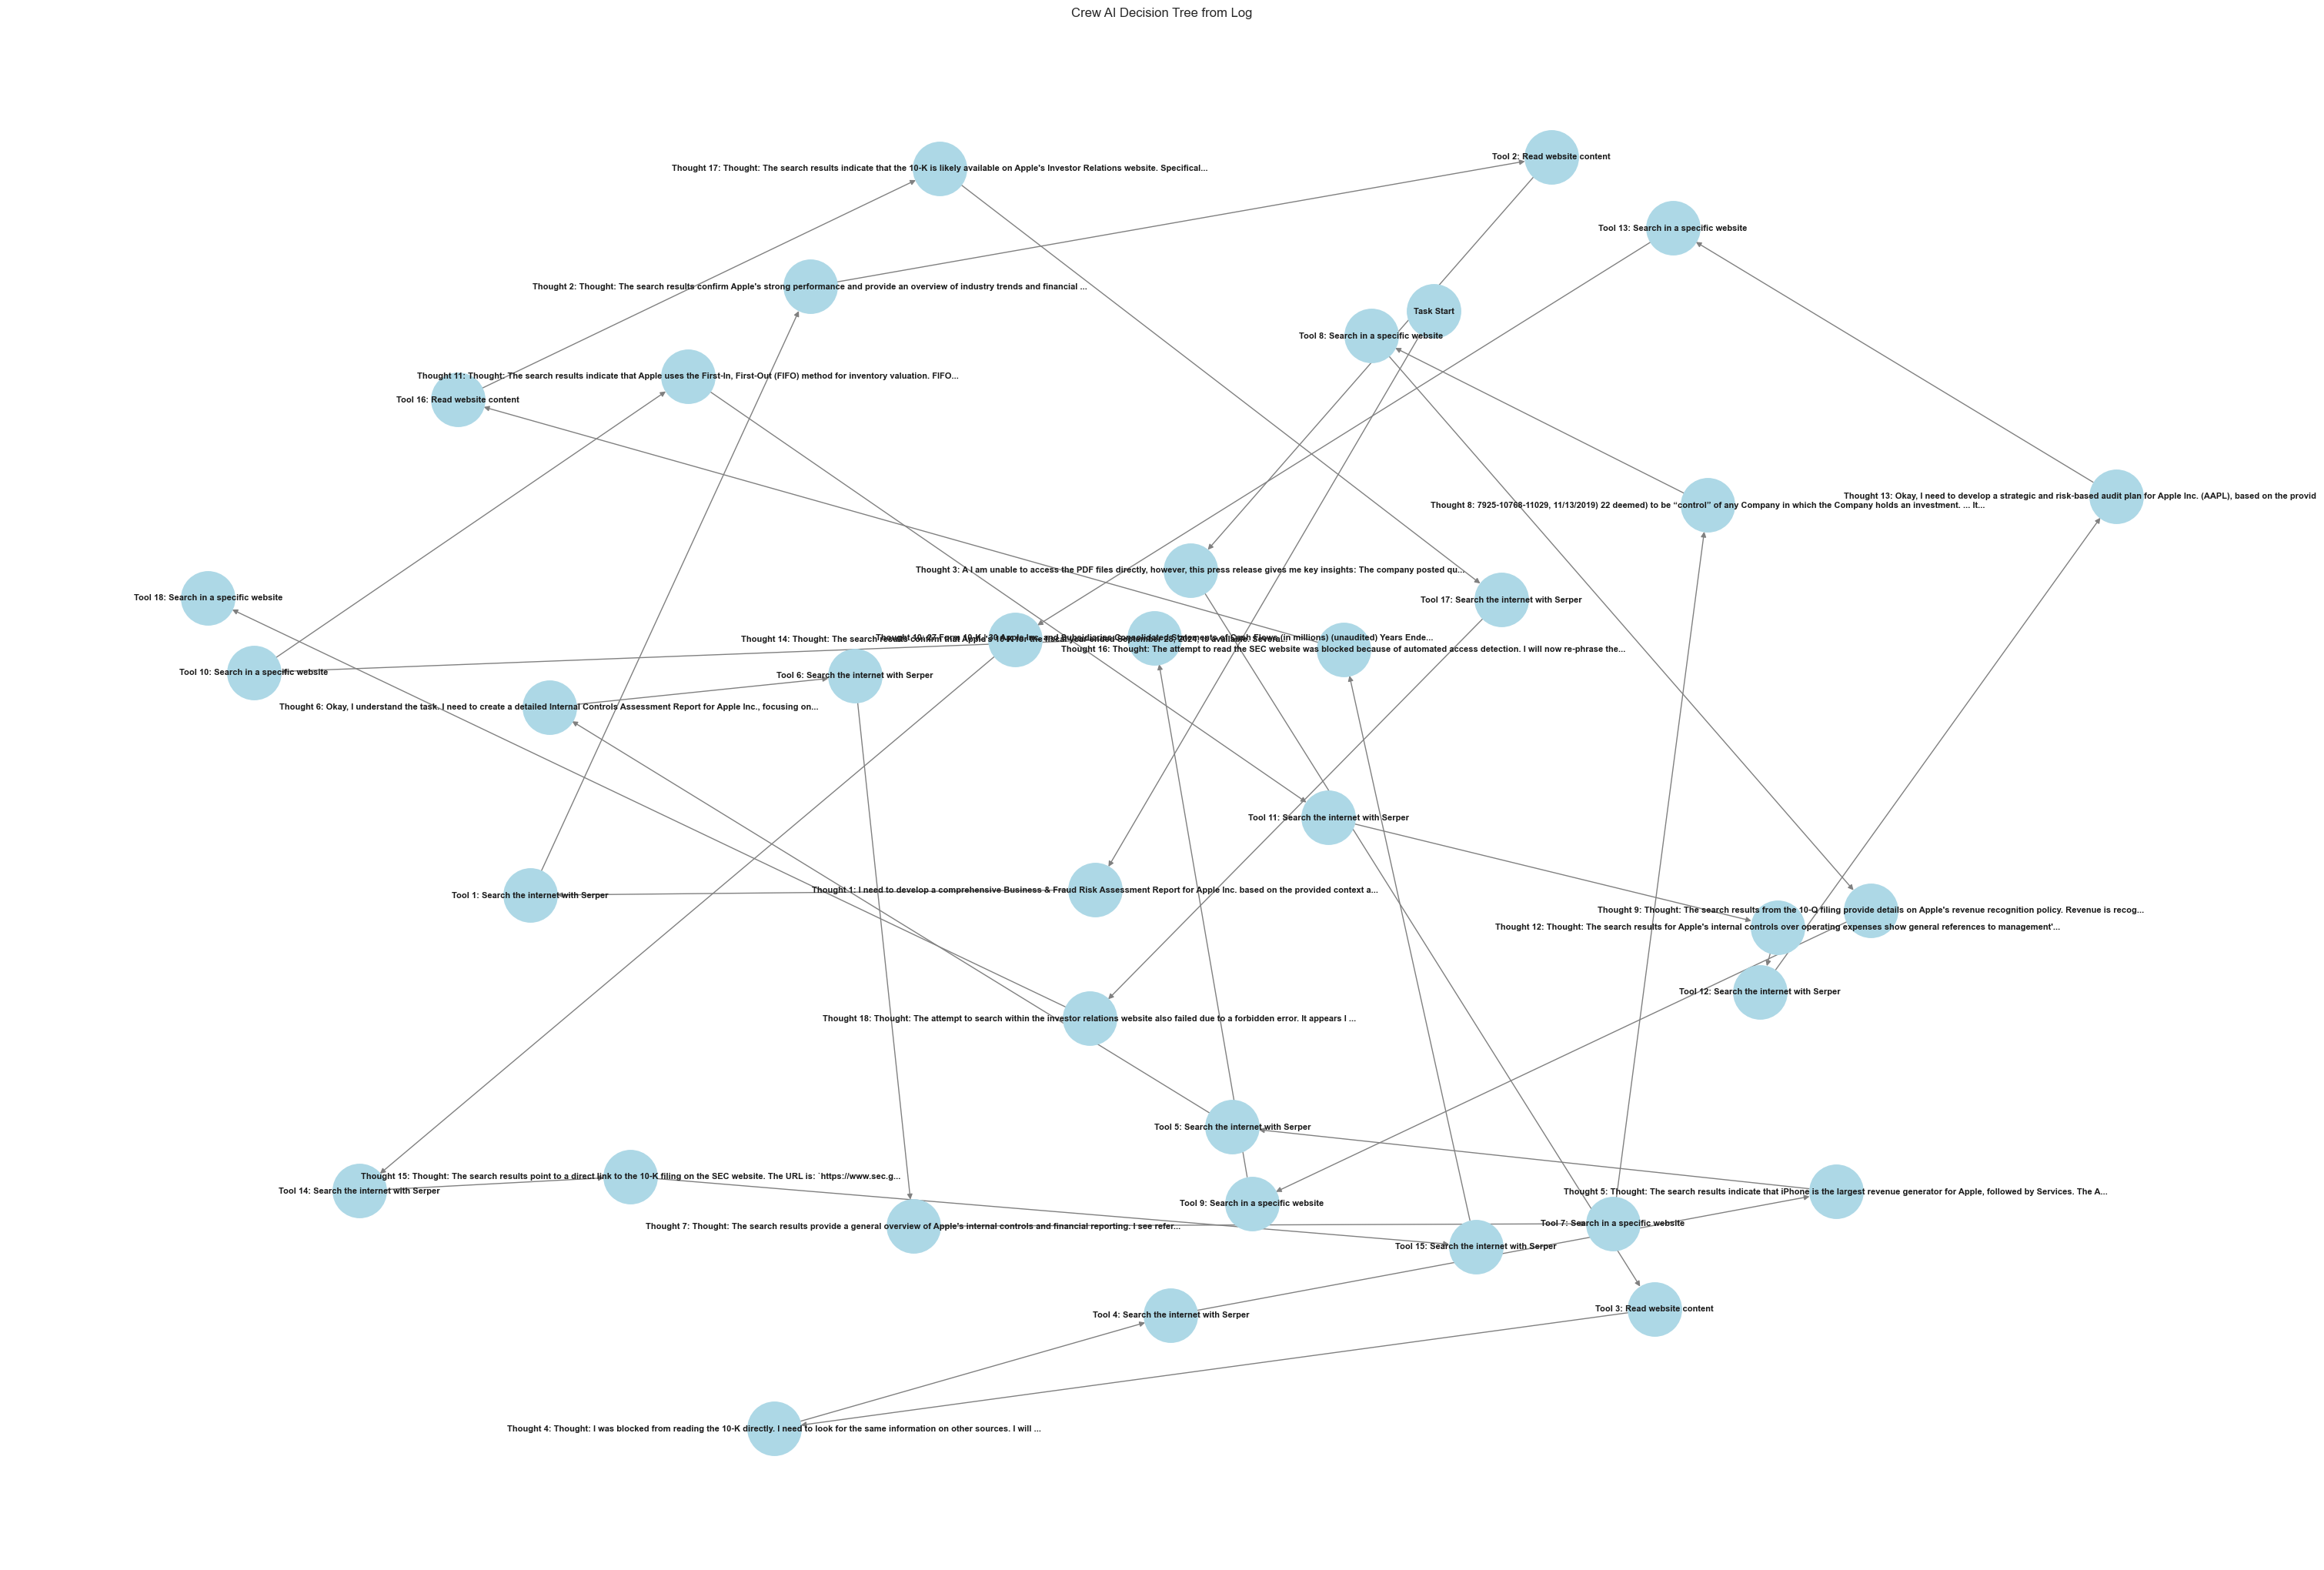

In [34]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt


# 🔍 Extract agent thoughts and tool usages
thought_pattern = r"## Thought:(.*?)## Using tool:"
tool_pattern = r"## Using tool: (.*?)\n## Tool Input:"

thoughts = re.findall(thought_pattern, raw_log, re.DOTALL)
tools = re.findall(tool_pattern, raw_log)

# 🧹 Clean and shorten text for display
thoughts = [t.strip().replace("\n", " ")[:120] + "..." if len(t.strip()) > 120 else t.strip() for t in thoughts]
tools = [t.strip() for t in tools]

#  Create a decision tree graph
G = nx.DiGraph()
G.add_node("Task Start")

for i in range(len(thoughts)):
    thought_node = f"Thought {i+1}: {thoughts[i]}"
    tool_node = f"Tool {i+1}: {tools[i]}" if i < len(tools) else None

    G.add_node(thought_node)
    G.add_edge("Task Start" if i == 0 else f"Tool {i}: {tools[i-1]}", thought_node)

    if tool_node:
        G.add_node(tool_node)
        G.add_edge(thought_node, tool_node)

plt.figure(figsize=(30, 20))
pos = nx.spring_layout(G, k=0.8, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightblue", font_size=8, font_weight='bold', edge_color="gray")
plt.title("Crew AI Decision Tree from Log")
plt.show()